# SQL de alto desempenho

<p><img src=https://irp-cdn.multiscreensite.com/b4e20866/NoSQL.jpg width=500></p>

## Introdução
No módulo anterior, desenvolvemos as habilidades necessárias para analisar efetivamente os dados em um banco de dados SQL e, neste módulo, voltaremos nossa atenção para a eficiência dessa análise, investigando como podemos aumentar o desempenho de nossas consultas SQL.

Eficiência e desempenho são componentes-chave da análise de dados, pois sem considerar esses fatores, restrições físicas, como tempo e poder de processamento, podem afetar significativamente o resultado de uma análise. Para elaborar essas limitações, podemos considerar dois cenários separados.

Digamos que estamos realizando uma **análise post-hoc** (análise após o fato ou evento). Neste primeiro cenário, concluímos um estudo e coletamos um grande conjunto de dados de observações individuais de vários fatores ou características diferentes. Um exemplo é o descrito em nosso banco de dados de vendas de concessionárias – analisando os dados de vendas de cada cliente. Com o processo de coleta de dados, queremos analisar os dados em busca de padrões e **insights** conforme especificado por nossa declaração do problema. Se nosso conjunto de dados for suficientemente grande, poderemos encontrar problemas rapidamente se não otimizarmos as consultas primeiro; o problema mais comum seria simplesmente o tempo gasto para executar as consultas. Embora isso não pareça um problema significativo, tempos de processamento desnecessariamente longos podem causar:
* Uma redução na profundidade da análise concluída. Como cada consulta leva muito tempo, a praticidade dos cronogramas do projeto pode limitar o número de consultas e, portanto, a profundidade e a complexidade da análise podem ser limitadas.
* A limitação da seleção de dados para análise. Ao reduzir artificialmente o conjunto de dados usando subamostragem, podemos concluir a análise em um tempo razoável, mas teríamos que sacrificar o número de observações usadas. Isso pode, por sua vez, levar à inclusão acidental de vieses na análise.
* A necessidade de usar muito mais recursos em paralelo para concluir a análise em um tempo razoável, aumentando assim o custo do projeto.

Da mesma forma, outro problema potencial com consultas abaixo do ideal é um aumento na memória necessária do sistema e no poder de computação. Isso pode resultar em um dos dois cenários a seguir:
* Prevenção da análise devido a recursos insuficientes
* Um aumento significativo no custo do projeto para recrutar os recursos necessários

Análises/consultas fazem parte de um serviço ou produto. Vamos pensar em um segundo cenário, em que a análise está sendo concluída como um componente de um serviço ou produto maior e, portanto, as consultas ao banco de dados podem precisar ser concluídas em tempo real, ou pelo menos em tempo quase real. Nesses casos, a otimização e a eficiência são fundamentais para o sucesso do produto.

Um exemplo é um sistema de navegação GPS que incorpora o estado do tráfego conforme relatado por outros usuários. Para que tal sistema seja eficaz e forneça informações de navegação atualizadas, o banco de dados deve ser analisado a uma taxa que acompanhe a velocidade do carro e o andamento da viagem. Qualquer atraso na análise que impeça a atualização da navegação em resposta ao tráfego teria um impacto significativo na viabilidade comercial do aplicativo.

Depois de examinar esses dois exemplos, podemos ver que, embora a eficiência seja importante em uma análise *post-hoc* eficaz e completa, ela é absolutamente crítica ao incorporar a análise de dados como um componente de um produto ou serviço separado. Embora certamente não seja o trabalho de um cientista de dados ou analista de dados garantir que a produção e o banco de dados estejam funcionando com eficiência ideal, é fundamental que as consultas da análise subjacente sejam tão eficazes quanto possível. Se não tivermos um banco de dados eficiente e atual em primeiro lugar, refinamentos adicionais não ajudarão a melhorar o desempenho da análise. Na próxima seção, discutiremos métodos para aumentar o desempenho de varreduras de informações em um banco de dados.

### Métodos de verificação de banco de dados
Os bancos de dados compatíveis com SQL fornecem vários métodos diferentes para varredura, pesquisa e seleção de dados. O método de verificação correto a ser usado depende muito do caso de uso e do estado do banco de dados no momento da verificação. Quantos registros estão no banco de dados? Em quais campos estamos interessados? Quantos registros esperamos que sejam devolvidos? Com que frequência precisamos executar a consulta? Estas são apenas algumas das perguntas que podemos fazer ao selecionar o método de digitalização mais adequado. Ao longo desta seção, descreveremos alguns dos métodos de pesquisa disponíveis, como eles são usados no SQL para executar varreduras e vários cenários em que eles devem/não devem ser usados.

In [1]:
# Importando o SqlAlchemy
import pandas as pd
from sqlalchemy import create_engine

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")

# Instanciando a Função create_engine com a string de conexão
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="admin",
    host="127.0.0.1",
    port=5432,
    database="sqlda"))

sql = """
		SELECT *
		FROM customers
		LIMIT 5
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
1,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02
2,3,None,Braden,Jordan,None,bjordan2@geocities.com,M,192.86.248.59,None,5651 Kennedy Park,Pensacola,FL,32590,30.6143,-87.2758,2018-10-27
3,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,Nashville,TN,37215,36.0986,-86.8219,2017-09-03
4,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,Miami,FL,33124,25.5584,-80.4582,2014-03-06


Extrair dados usando o comando **SELECT** diretamente do banco de dados executa uma varredura sequencial, onde o servidor de banco de dados percorre cada registro no banco de dados e compara cada registro com os critérios da varredura sequencial, retornando os registros que correspondem aos critérios. Esta é essencialmente uma varredura de força bruta e, portanto, sempre pode ser chamada para executar uma pesquisa. Em muitas situações, uma varredura sequencial também é o método mais eficiente e será selecionada automaticamente pelo servidor SQL. Este é particularmente o caso se qualquer uma das seguintes condições for verdadeira:
* A mesa é bem pequena. Por exemplo, pode não conter um grande número de registros.
* O campo utilizado na pesquisa contém um alto número de duplicatas.
* O planejador determina que a varredura sequencial seria igualmente eficiente ou mais eficiente para os critérios fornecidos do que qualquer outra varredura.

Neste exercício, apresentaremos o comando **EXPLAIN**, que exibe o plano para uma consulta antes de ser executada. Quando usamos o comando **EXPLAIN** em combinação com uma instrução SQL, o interpretador SQL não executa a instrução, mas retorna os passos que serão executados (um plano de consulta) pelo interpretador para retornar os resultados desejados. Há muitas informações retornadas em um plano de consulta e ser capaz de compreender a saída é vital para ajustar o desempenho de nossas consultas de banco de dados. O planejamento de consulta é um tópico complexo e pode exigir alguma prática para se sentir confortável na interpretação da saída; até mesmo a documentação oficial do PostgreSQL observa que a leitura de planos é uma arte que merece atenção significativa por si só. Começaremos com um plano simples e passaremos por consultas e planos de consulta mais complicados.

### Exercício 26: Interpretando o Planejador de Consultas
Neste exercício, interpretaremos um planejador de consulta usando o comando **EXPLAIN**. Vamos interpretar o planejador de consultas da tabela de emails do banco de dados *sqlda*. Em seguida, empregaremos uma consulta mais envolvente, procurando por datas entre dois valores específicos no campo **clicked_date**. Precisaremos garantir que o banco de dados **sqlda** seja carregado conforme descrito no Prefácio.
Recupere o arquivo Exercise26.sql do código-fonte que o acompanha. Este arquivo conterá todas as consultas usadas neste exercício. No entanto, vamos inseri-los manualmente usando o interpretador SQL para reforçar nossa compreensão da operação do planejador de consultas.

In [2]:
sql = """
		EXPLAIN SELECT * FROM emails;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on emails (cost=0.00..9606.58 rows=4...


Essas informações são retornadas pelo planejador de consultas; embora este seja o exemplo mais simples possível, há bastante coisa para descompactar nas informações do planejador, então vamos examinar a saída passo a passo:

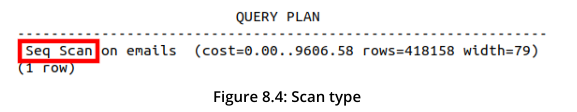

In [2]:
from IPython.display import Image
Image('images/scan_type.PNG')

O primeiro aspecto do plano fornecido é o tipo de varredura executada pela consulta. Abordaremos mais tipos de varredura mais adiante neste módulo, mas, conforme discutido com mais detalhes em breve, a Varredura Seq (consulte a Figura 8.4), ou varredura sequencial, é um tipo de consulta simples, porém robusto:

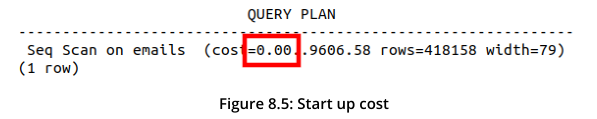

In [4]:
Image('images/start_up_cost.PNG')

A primeira medida relatada pelo planejador, conforme mostrado na Figura 8.5, é o custo inicial, que é o tempo gasto antes do início da varredura. Esse tempo pode ser necessário para primeiro classificar os dados ou concluir outros aplicativos de pré-processamento. Também é importante notar que o tempo medido é realmente relatado em unidades de custo (veja a Figura 8.5) em oposição a segundos ou milissegundos. Muitas vezes, as unidades de custo são uma indicação do número de solicitações de disco ou buscas de página feitas, em vez de ser uma medida em termos absolutos. O custo informado normalmente é mais útil como meio de comparar o desempenho de várias consultas, e não como uma medida absoluta de tempo:

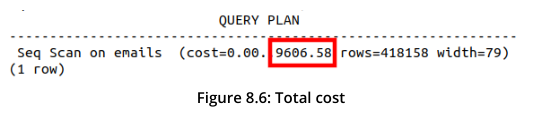

In [5]:
Image('images/total_cost.PNG')

O próximo número na sequência (veja a Figura 8.6) indica o custo total de execução da consulta se todas as linhas disponíveis forem recuperadas. Existem algumas circunstâncias em que todas as linhas disponíveis podem não ser recuperadas, mas abordaremos isso em breve:


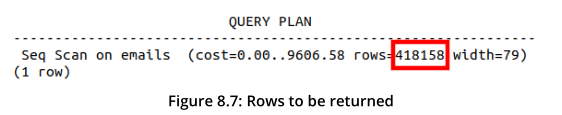

In [6]:
Image('images/rows_returned.PNG')


A próxima figura no plano (veja a Figura 8.7) indica o número total de linhas que estão disponíveis para serem retornadas – novamente, se o plano for completamente executado:

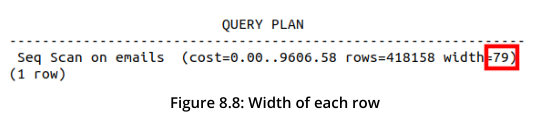

In [7]:
Image('images/width_row.PNG')

A figura final (veja a Figura 8.8), conforme sugerido por seu rótulo, indica a largura de cada linha em bytes.

> ##### Observação
> Ao executar o comando **EXPLAIN**, o **PostgreSQL** não implementa a consulta nem retorna os valores. No entanto, ele retorna uma descrição, juntamente com os custos de processamento envolvidos na execução de cada etapa do plano.

3. Consulte o plano de consulta na tabela de emails e defina o limite como 5. Insira a seguinte instrução no interpretador do PostgreSQL:

In [8]:
sql = """
		EXPLAIN SELECT *
		FROM emails
		LIMIT 5;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Limit (cost=0.00..0.11 rows=5 width=79)
1,-> Seq Scan on emails (cost=0.00..9606.58 ...


Isso repete a afirmação anterior, onde o planejador está limitado aos cinco primeiros registros. Essa consulta produziu a seguinte saída do planejador, conforme anterior.

Referindo-se à tabela anterior, podemos ver que há duas linhas individuais no plano. Isso indica que o plano é composto por duas etapas distintas, sendo a linha inferior do plano (ou, neste caso, a primeira etapa a ser executada) uma repetição daquela mostrada na Figura 8.8. A linha superior do plano é o componente que limita o resultado a apenas **5** linhas. O processo **Limit** é um custo adicional da consulta; no entanto, é bastante insignificante em comparação com o plano de nível inferior, que recupera aproximadamente **418.158** linhas a um custo de solicitações de **9.606** páginas. O estágio **Limit** retorna apenas **5** linhas a um custo de **0,11** solicitações de página.

> ##### Observação
> O custo total estimado para uma solicitação compreende o tempo necessário para recuperar as informações do disco, bem como o número de linhas que precisam ser verificadas. Os parâmetros internos, **seq_page_cost** e **cpu_tuple_cost**, definem o custo das operações correspondentes dentro do tablespace do banco de dados. Embora não seja recomendado nesta fase, essas duas variáveis podem ser alteradas para modificar as etapas preparadas pelo planejador.

4. Agora, empregue uma consulta mais complexa, procurando por datas entre dois valores específicos na coluna **clicked_date**. Insira a seguinte instrução no interpretador *PostgreSQL*:

In [9]:
sql = """
		EXPLAIN SELECT *
		FROM emails
		WHERE clicked_date BETWEEN '2011-01-01' and '2011-02-01';
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Gather (cost=1000.00..9051.79 rows=133 width=79)
1,Workers Planned: 2
2,-> Parallel Seq Scan on emails (cost=0.00....
3,Filter: ((clicked_date >= '2011-01-01 ...


O primeiro aspecto deste plano de consulta a ser observado é que ele compreende algumas etapas diferentes. A consulta de nível inferior é semelhante à consulta anterior, pois executa uma varredura sequencial. No entanto, em vez de limitar a saída, estamos filtrando-a com base nas strings de carimbo de data/hora fornecidas. Observe que a varredura sequencial deve ser concluída em paralelo, conforme indicado pelo **Parallel Seq Scan**, e o fato de que dois trabalhadores estão planejados para serem usados. Cada varredura de sequência individual deve retornar aproximadamente 54 linhas, com um custo de 8038,49 para ser concluída. O nível superior do plano é um estado **Gather**, que é executado no início da consulta. Podemos ver aqui pela primeira vez que os custos iniciais são diferentes de zero (1.000) e totalizam **9.051,49**, incluindo as etapas de coleta e pesquisa.

Neste exercício, trabalhamos com o planejador de consultas e a saída do comando **EXPLAIN**. Essas consultas relativamente simples destacaram vários recursos do planejador de consultas SQL, bem como as informações detalhadas fornecidas por ele. Ter um bom entendimento do planejador de consultas e das informações que ele está retornando a você será muito útil em seus esforços de ciência de dados. Apenas lembre-se de que esse entendimento virá com o tempo e a prática; nunca hesite em consultar a documentação do PostgreSQL: https://www.postgresql.org/docs/current/using-explain.html.
Continuaremos a praticar a leitura de planos de consulta ao longo deste módulo à medida que examinamos os diferentes tipos de varredura e os métodos que eles usam para melhorar o desempenho.

### Atividade 10: Planejamento de consultas
Nosso objetivo nesta atividade é consultar o plano de leitura e interpretação das informações retornadas pelo planejador. Digamos que ainda estamos lidando com nosso banco de dados sqlda de registros de clientes e que nossa equipe financeira gostaria que implementássemos um sistema para gerar regularmente um relatório da atividade do cliente em uma região geográfica específica. Para garantir que nosso relatório possa ser executado em tempo hábil, precisamos de uma estimativa de quanto tempo as consultas SQL levarão. Usaremos o comando **EXPLAIN** para descobrir quanto tempo algumas das consultas de relatório levarão:
1. Abra o PostgreSQL e conecte-se ao banco de dados **sqlda**.
2. Use o comando **EXPLAIN** para retornar o plano de consulta para selecionar todos os registros disponíveis na tabela de clientes.
3. Leia a saída do plano e determine o custo total da consulta, o custo de configuração, o número de linhas a serem retornadas e a largura de cada linha. Observando a saída, quais são as unidades para cada um dos valores retornados do plano após realizar esta etapa?
4. Repita a consulta da etapa 2 desta atividade, desta vez limitando o número de registros retornados a **15**.
Observando o plano de consulta atualizado, quantas etapas estão envolvidas no plano de consulta? Qual é o custo da etapa de limitação?
5. Gere o plano de consulta, selecionando todas as linhas onde os clientes moram dentro de uma latitude de **30** e **40** graus. Qual é o custo total do plano, bem como o número de linhas retornadas pela consulta?

In [10]:
# Nr 2
sql = """
		EXPLAIN SELECT *
		FROM customers;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on customers (cost=0.00..1536.00 row...


In [11]:
# Nr 3
sql = """
		EXPLAIN SELECT *
		FROM customers
		LIMIT 15;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Limit (cost=0.00..0.46 rows=15 width=140)
1,-> Seq Scan on customers (cost=0.00..1536....


In [12]:
# Nr 3
sql = """
		EXPLAIN SELECT *
		FROM customers
		WHERE latitude > 30 AND latitude <40
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on customers (cost=0.00..1786.00 row...
1,Filter: ((latitude > '30'::double precision)...


Nesta atividade, praticamos a leitura dos planos retornados pelo planejador de consultas. Conforme discutido anteriormente, a leitura de planos requer prática substancial para dominá-la. Esta atividade iniciou este processo e é altamente recomendável que você use frequentemente o comando **EXPLAIN** para melhorar a leitura do seu plano.
### Verificação de índice
As varreduras de índice são um método de melhorar o desempenho de nossas consultas de banco de dados. As varreduras de índice diferem da varredura sequencial, pois uma etapa de pré-processamento é executada antes que a pesquisa de registros do banco de dados possa ocorrer. A maneira mais simples de pensar em uma varredura de índice é como o índice de um texto ou livro de referência. Ao escrever um livro de não-ficção, um editor analisa o conteúdo do livro e escreve os números das páginas correspondentes a cada tópico classificado em ordem alfabética. Assim como o editor faz o esforço inicial de criar um índice para referência do leitor, também podemos criar um índice semelhante dentro do banco de dados *PostgreSQL*. Esse índice dentro do banco de dados cria um conjunto preparado e organizado ou um subconjunto de referências aos dados sob condições especificadas. Quando uma consulta é executada e está presente um índice que contém informações relevantes para a consulta, o planejador pode optar por usar os dados que foram pré-processados e pré-organizados no índice. Sem usar um índice, o banco de dados precisa varrer repetidamente todos os registros, verificando cada registro quanto às informações de interesse.

Mesmo que todas as informações desejadas estejam no início do banco de dados, sem indexação, a pesquisa ainda varrerá todos os registros disponíveis. Claramente, isso levaria um tempo significativamente maior do que o necessário.
Existem várias estratégias de indexação diferentes que o *PostgreSQL* pode usar para criar pesquisas mais eficientes, incluindo **árvores B (B-tree), índices de hash, índices invertidos generalizados (GINs)** e **árvores de pesquisa generalizadas (GISTs)**. Cada um desses diferentes tipos de índice tem seus próprios pontos fortes e fracos e, portanto, é usado em diferentes situações. Um dos índices mais usados é o B-tree, que é a estratégia de indexação padrão usada pelo *PostgreSQL* e está disponível em quase todos os softwares de banco de dados. Primeiro, passaremos algum tempo investigando o índice da árvore B, analisando o que o torna útil, bem como algumas de suas limitações.
### O índice da árvore B
O índice B-tree é um tipo de árvore de busca binária e se caracteriza pelo fato de ser uma estrutura auto-balanceada, mantendo uma estrutura de dados própria para busca eficiente. Uma estrutura genérica de árvore B pode ser encontrada na Figura 8.12, na qual podemos ver que cada nó na árvore não tem mais do que dois elementos (dando assim equilíbrio) e que o primeiro nó tem dois filhos. Essas características são comuns entre as árvores B, onde cada nó é limitado a n componentes, forçando assim a divisão em nós filhos. Os ramos das árvores terminam nos nós folha, que, por definição, não têm filhos:

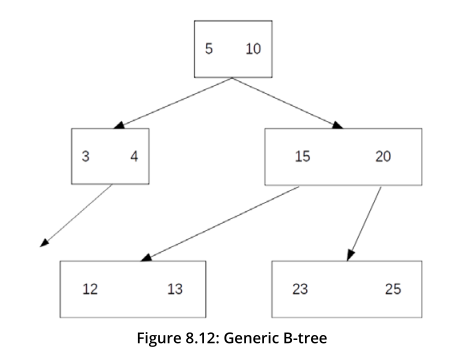

In [13]:
Image('images/b-tree.PNG')

Usando a Figura 8.12 como exemplo, digamos que estivéssemos procurando o número 13 no índice da árvore B. Começaríamos no primeiro nó e selecionaríamos se o número era menor que 5 ou maior que 10. Isso nos levaria ao galho direito da árvore, onde novamente escolheríamos entre menor que 15 e maior que 20. então selecionaria menos de 15 e chegaria à localização de 13 no índice. Podemos ver imediatamente que esta operação seria muito mais rápida do que examinar todos os valores disponíveis. Também podemos ver que, para desempenho, a árvore deve ser equilibrada para permitir um caminho fácil para a travessia. Além disso, deve haver informações suficientes para permitir a divisão. Se tivéssemos um índice de árvore com apenas alguns valores possíveis para dividir e um grande número de amostras, simplesmente dividiríamos os dados em alguns grupos.

Considerando *B-trees* (árvores B) no contexto de busca de banco de dados, podemos ver que precisamos de uma condição para dividir as informações (ou divisão), e também precisamos de informações suficientes para uma divisão significativa. Não precisamos nos preocupar com a lógica de seguir a árvore, pois ela será gerenciada pelo próprio banco de dados e pode variar de acordo com as condições de busca. Mesmo assim, é importante que entendamos os pontos fortes e fracos do método para que possamos fazer escolhas apropriadas ao criar o índice para um desempenho ideal.

Para criar um índice para um conjunto de dados, usamos a seguinte sintaxe:

`CREATE INDEX <index name> ON <table name>(table column);`

Também podemos adicionar condições e restrições adicionais para tornar o índice mais seletivo:

`CREATE INDEX <index name> ON <table name> USING TYPE(table column)`

Por exemplo:

In [15]:
sql = """
		CREATE INDEX ix_customers ON customers USING BTREE(customer_id);
      """
engine.execute(sql)

No próximo exercício, vamos começar com um plano simples e trabalhar mais consultas complicadas e planos de consulta usando varreduras de índice.

### Exercício 27: Criando uma varredura de índice
Neste exercício, criaremos várias varreduras de índice diferentes e investigaremos as características de desempenho de cada uma das varreduras.

Continuando com o cenário da atividade anterior, digamos que concluímos nosso serviço de relatórios, mas queríamos agilizar as consultas. Tentaremos melhorar esse desempenho usando indexação e varreduras de índice. Você deve se lembrar de que estamos usando uma tabela de informações do cliente que inclui detalhes de contato como nome, endereço de e-mail, número de telefone e informações de endereço, bem como os detalhes de latitude e longitude de seu endereço. A seguir estão as etapas a serem executadas:
1. Certifique-se de que o banco de dados **sqlda** seja carregado conforme descrito no *Prefácio*. Recupere o arquivo **Exercise27.sql** do código-fonte que o acompanha. Este arquivo conterá todas as consultas usadas neste exercício; no entanto, vamos inseri-los manualmente usando o interpretador SQL para reforçar nossa compreensão da operação do planejador de consultas.

In [16]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE state='FO';
      """
engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1661.00 rows=1 width=140)',),
 ("  Filter: (state = 'FO'::text)",)]

Observe que há apenas 1 linha retornada e que o custo de configuração é 0, mas o custo total da consulta é 1661.

4. Determine quantos valores de estado exclusivos existem, novamente usando o comando **EXPLAIN**:

In [17]:
sql = """
		EXPLAIN SELECT DISTINCT state FROM customers;
      """
engine.execute(sql).fetchall()

[('HashAggregate  (cost=1661.00..1661.51 rows=51 width=3)',),
 ('  Group Key: state',),
 ('  ->  Seq Scan on customers  (cost=0.00..1536.00 rows=50000 width=3)',)]

Portanto, existem 51 valores exclusivos na coluna de estado.

5. Crie um índice chamado **ix_state** usando a coluna de estado dos clientes:

In [18]:
sql = """
		CREATE INDEX ix_state ON customers(state);
      """
engine.execute(sql)

6. Execute novamente a instrução EXPLAIN da etapa 5:

In [21]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE state='FO';
      """
engine.execute(sql).fetchall()

[('Index Scan using ix_state on customers  (cost=0.29..8.30 rows=1 width=140)',),
 ("  Index Cond: (state = 'FO'::text)",)]

Observe que uma varredura de índice agora está sendo usada usando o índice que acabamos de criar na etapa 5. Também podemos ver que temos um custo de configuração diferente de zero (**0,29**), mas o custo total é muito reduzido, do anterior **1661** para apenas **8,31**! Este é o poder da varredura de índice.

Agora, vamos ver um exemplo um pouco diferente, observando o tempo que leva para retornar uma pesquisa na coluna de **gênero**.

7. Use o comando **EXPLAIN** para retornar o plano de consulta para uma pesquisa de todos os registros de homens no banco de dados:

In [22]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE gender='M';
      """
engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1661.00 rows=25105 width=140)',),
 ("  Filter: (gender = 'M'::text)",)]

8. Crie um índice chamado **ix_gender** usando a coluna de **gênero** dos clientes:

In [6]:
sql = """
		CREATE INDEX ix_state ON customers(gender);
      """
engine.execute(sql)

In [7]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE gender='M';
      """
engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=286.85..1636.67 rows=25105 width=140)',),
 ("  Recheck Cond: (gender = 'M'::text)",),
 ('  ->  Bitmap Index Scan on ix_state  (cost=0.00..280.58 rows=25105 width=0)',),
 ("        Index Cond: (gender = 'M'::text)",)]

Observe que o plano de consulta não mudou, apesar do uso da varredura de índice. Isso ocorre porque não há informações suficientes para criar uma árvore útil na coluna de gênero. Existem apenas dois valores possíveis, **M** e **F**. O índice de gênero essencialmente divide a informação em dois; um ramo para machos e outro para fêmeas. O índice não dividiu os dados em ramos da árvore o suficiente para obter qualquer benefício. O planejador ainda precisa varrer sequencialmente pelo menos metade dos dados e, portanto, não vale a pena a sobrecarga do índice. É por esse motivo que o planejador de consultas insiste em não usar o índice.

11. Use EXPLAIN para retornar o plano de consulta, procurando latitudes menores que 38 graus e maiores que 30 graus:

In [8]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE (latitude < 38) AND (latitude > 30);
      """
engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1786.00 rows=17843 width=140)',),
 ("  Filter: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",)]

12. Crie um índice chamado **ix_latitude** usando a coluna de latitude dos clientes:

In [11]:
sql = """
		CREATE INDEX ix_latitude ON customers(latitude);
      """
engine.execute(sql)

In [12]:
sql = """
		EXPLAIN SELECT * FROM customers WHERE (latitude < 38) AND (latitude > 30);
      """
engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=383.18..1686.83 rows=17843 width=140)',),
 ("  Recheck Cond: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",),
 ('  ->  Bitmap Index Scan on ix_latitude  (cost=0.00..378.72 rows=17843 width=0)',),
 ("        Index Cond: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",)]

Podemos ver que o plano é muito mais complexo do que o anterior, com uma varredura de heap de bitmap e uma varredura de índice de bitmap sendo usadas. Abordaremos as varreduras de bitmap em breve, mas primeiro, vamos obter mais informações adicionando o comando **ANALYZE** a **EXPLAIN**.

14. Use **EXPLAIN ANALYZE** para consultar o plano de conteúdo da tabela de clientes com valores de latitude entre 30 e 38:

In [13]:
sql = """
		EXPLAIN ANALYZE SELECT * FROM customers WHERE (latitude < 38) AND (latitude > 30);
	  """
engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=383.18..1686.83 rows=17843 width=140) (actual time=1.568..3.988 rows=17896 loops=1)',),
 ("  Recheck Cond: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",),
 ('  Heap Blocks: exact=1036',),
 ('  ->  Bitmap Index Scan on ix_latitude  (cost=0.00..378.72 rows=17843 width=0) (actual time=1.464..1.464 rows=17896 loops=1)',),
 ("        Index Cond: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",),
 ('Planning Time: 0.120 ms',),
 ('Execution Time: 4.327 ms',)]

Com essas informações extras, podemos ver que há **0,120 ms** de tempo de planejamento e **4,327 ms** de tempo de execução, com a varredura de índice levando quase o mesmo tempo para executar que a varredura de calor de bitmap leva para iniciar.

15. Agora, vamos criar outro índice onde a latitude está entre 30 e 38 na tabela de clientes:

In [14]:
sql = """
		CREATE INDEX ix_latitude_less ON customers(latitude) WHERE (latitude < 38) and (latitude > 30);
	  """
engine.execute(sql)

In [16]:
sql = """
		EXPLAIN ANALYZE SELECT * FROM customers WHERE (latitude < 38) AND (latitude > 30);
	  """
engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=297.96..1601.61 rows=17843 width=140) (actual time=1.321..3.241 rows=17896 loops=1)',),
 ("  Recheck Cond: ((latitude < '38'::double precision) AND (latitude > '30'::double precision))",),
 ('  Heap Blocks: exact=1036',),
 ('  ->  Bitmap Index Scan on ix_latitude_less  (cost=0.00..293.50 rows=17843 width=0) (actual time=1.217..1.218 rows=17896 loops=1)',),
 ('Planning Time: 0.469 ms',),
 ('Execution Time: 3.616 ms',)]

Usando esse índice mais direcionado, conseguimos reduzir 0,681 ms do tempo de execução, ao custo de 0,3 ms adicionais de tempo de planejamento. Assim, extraímos algum desempenho adicional de nossa consulta, pois nossos índices tornaram o processo de pesquisa mais eficiente. Talvez tenhamos que pagar um custo inicial para criar o índice, mas, uma vez criado, as consultas repetidas podem ser executadas mais rapidamente.

### Atividade 11: Implementando verificações de índice
Nesta atividade, determinaremos se as varreduras de índice podem ser usadas para reduzir o tempo de consulta. Depois de criar nosso sistema de relatórios de clientes para o departamento de marketing na Atividade 10: Planejamento de consultas, recebemos outra solicitação para permitir que os registros sejam identificados por seu endereço IP ou pelos nomes de clientes associados. Sabemos que existem muitos endereços IP diferentes e precisamos de pesquisas de alto desempenho. Planeje as consultas necessárias para pesquisar registros por endereço IP, bem como para determinados clientes com o sufixo Jr em seu nome.
Aqui estão os passos a seguir:
1. Use os comandos EXPLAIN e ANALYZE para criar o perfil do plano de consulta para pesquisar todos os registros com um endereço IP de 18.131.58.65. Quanto tempo leva para planejar e executar a consulta?
2. Crie um índice genérico com base na coluna de endereço IP.
3. Execute novamente a consulta da etapa 1. Quanto tempo leva para planejar e executar a consulta?
4. Crie um índice mais detalhado com base na coluna de endereço IP com a condição de que o endereço IP seja 18.131.58.65.

5. Execute novamente a consulta da etapa 1. Quanto tempo leva para planejar e executar a consulta? Quais são as diferenças entre cada uma dessas consultas?
6. Use os comandos EXPLAIN e ANALYZE para traçar o perfil do plano de consulta para pesquisar todos os registros com o sufixo Jr. Quanto tempo leva para planejar e executar a consulta?
7. Crie um índice genérico com base na coluna de endereço do sufixo.
8. Execute novamente a consulta da etapa 6. Quanto tempo leva para planejar e executar a consulta?

In [17]:
# Nr 1
sql = """
		EXPLAIN ANALYZE SELECT * FROM customers WHERE ip_address = '18.131.58.65';
	  """
engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1661.00 rows=1 width=140) (actual time=0.022..5.756 rows=1 loops=1)',),
 ("  Filter: (ip_address = '18.131.58.65'::text)",),
 ('  Rows Removed by Filter: 49999',),
 ('Planning Time: 0.141 ms',),
 ('Execution Time: 5.785 ms',)]

In [19]:
# Nr 2
sql = """
      CREATE INDEX ON customers(ip_address);
      """
engine.execute(sql)

# Nr 3
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE ip_address = '18.131.58.65';
      """
engine.execute(sql).fetchall()

[('Index Scan using customers_ip_address_idx2 on customers  (cost=0.29..8.31 rows=1 width=140) (actual time=0.026..0.026 rows=1 loops=1)',),
 ("  Index Cond: (ip_address = '18.131.58.65'::text)",),
 ('Planning Time: 0.396 ms',),
 ('Execution Time: 0.036 ms',)]

In [20]:
# Nr 4
sql = """
      CREATE INDEX ix_ip_where ON customers(ip_address) WHERE ip_address = '18.131.58.65';
      """

engine.execute(sql)

# Nr 5
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE ip_address = '18.131.58.65';
      """
engine.execute(sql).fetchall()


[('Index Scan using ix_ip_where on customers  (cost=0.13..8.14 rows=1 width=140) (actual time=0.015..0.015 rows=1 loops=1)',),
 ('Planning Time: 0.279 ms',),
 ('Execution Time: 0.024 ms',)]

In [21]:
# Nr 6
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE suffix = 'Jr';
      """

engine.execute(sql).fetchall()


[('Seq Scan on customers  (cost=0.00..1661.00 rows=85 width=140) (actual time=0.017..4.030 rows=102 loops=1)',),
 ("  Filter: (suffix = 'Jr'::text)",),
 ('  Rows Removed by Filter: 49898',),
 ('Planning Time: 0.193 ms',),
 ('Execution Time: 4.055 ms',)]

In [22]:
# Nr 7
sql = """
      CREATE INDEX ix_jr ON customers(suffix);
      """

engine.execute(sql)

# Nr 8
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE suffix = 'Jr';
      """

engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=4.95..264.80 rows=85 width=140) (actual time=0.046..0.100 rows=102 loops=1)',),
 ("  Recheck Cond: (suffix = 'Jr'::text)",),
 ('  Heap Blocks: exact=100',),
 ('  ->  Bitmap Index Scan on ix_jr  (cost=0.00..4.93 rows=85 width=0) (actual time=0.032..0.032 rows=102 loops=1)',),
 ("        Index Cond: (suffix = 'Jr'::text)",),
 ('Planning Time: 0.278 ms',),
 ('Execution Time: 0.127 ms',)]

### Índice de hash
O tipo de indexação final que abordaremos é o índice de hash. O índice de hash só recentemente ganhou estabilidade como um recurso no PostgreSQL, com versões anteriores emitindo avisos de que o recurso não é seguro e relatando que o método normalmente não é tão eficiente quanto os índices de árvore B (*B-tree*). No momento da escrita, o recurso de índice de hash é relativamente limitado nas instruções comparativas que pode executar, sendo a igualdade (=) a única disponível. Então, dado que o recurso é apenas estável e um pouco limitado em opções de uso, por que alguém o usaria? Bem, os índices de hash são capazes de descrever grandes conjuntos de dados (na ordem de dezenas de milhares de linhas ou mais) usando muito poucos dados, permitindo que mais dados sejam mantidos na memória e reduzindo o tempo de pesquisa para algumas consultas. Isso é particularmente importante para bancos de dados com pelo menos vários gigabytes de tamanho.

Um índice de hash é um método de indexação que utiliza uma função de hash para obter seus benefícios de desempenho. Uma função de hash é uma função matemática que recebe dados ou uma série de dados e retorna um comprimento exclusivo de caracteres alfanuméricos, dependendo de quais informações foram fornecidas e do código de hash exclusivo usado. Digamos que tivéssemos um cliente chamado "Josephine Marquez". Poderíamos passar essas informações para uma função de hash, que poderia produzir um resultado de hash como 01f38e. Digamos que também tivéssemos registros do marido de Josephine, Julio; o hash correspondente para Julio pode ser 43eb38a. Um mapa de hash usa um relacionamento de par chave-valor para localizar dados. Poderíamos (mas não estamos limitados a) usar os valores de uma função hash para fornecer a chave, usando os dados contidos na linha correspondente do banco de dados como valor. Desde que a chave seja exclusiva do valor, podemos acessar rapidamente as informações de que precisamos. Esse método também pode reduzir o tamanho geral do índice na memória, se apenas os hashes correspondentes forem armazenados, reduzindo drasticamente o tempo de pesquisa de uma consulta.

O exemplo a seguir mostra como criar um índice de hash:

`sqlda=# CREATE INDEX ix_gender ON customers USING HASH(gender);`

Você deve se lembrar de que o planejador de consultas pode ignorar os índices criados se considerar que eles não são significativamente mais rápidos para a consulta existente ou simplesmente inadequados. Como a varredura de hash é um pouco limitada em uso, pode não ser incomum que uma pesquisa diferente ignore os índices.

### Exercício 28: Gerando vários índices de hash para investigar o desempenho
Neste exercício, geraremos vários índices de hash e investigaremos os potenciais aumentos de desempenho que podem ser obtidos com o uso deles. Iniciaremos o exercício executando novamente algumas das consultas dos exercícios anteriores e comparando os tempos de execução:

1. Elimine todos os índices existentes usando o comando DROP INDEX:

In [29]:
sql = """
      DROP INDEX idx_gender;
      """

engine.execute(sql)

In [30]:
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE gender='M';
      """

engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1661.00 rows=25105 width=140) (actual time=0.014..6.228 rows=24956 loops=1)',),
 ("  Filter: (gender = 'M'::text)",),
 ('  Rows Removed by Filter: 25044',),
 ('Planning Time: 0.424 ms',),
 ('Execution Time: 6.672 ms',)]

3. Crie um índice de árvore B na coluna de gênero e repita a consulta para determinar o desempenho usando o índice padrão:

In [32]:
sql = """
      CREATE INDEX ix_gender ON customers USING btree(gender);
      """

engine.execute(sql)

# Repetindo a Query
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE gender='M';
      """

engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=286.85..1636.67 rows=25105 width=140) (actual time=0.678..2.822 rows=24956 loops=1)',),
 ("  Recheck Cond: (gender = 'M'::text)",),
 ('  Heap Blocks: exact=1036',),
 ('  ->  Bitmap Index Scan on ix_gender  (cost=0.00..280.58 rows=25105 width=0) (actual time=0.589..0.589 rows=24956 loops=1)',),
 ("        Index Cond: (gender = 'M'::text)",),
 ('Planning Time: 0.320 ms',),
 ('Execution Time: 3.298 ms',)]

Podemos ver aqui que o planejador de consulta não selecionou o índice da árvore B, mas sim a varredura sequencial. Os custos das varreduras não diferem, mas as estimativas de tempo de planejamento e execução foram modificadas. Isso não é inesperado, pois essas medidas são exatamente isso – estimativas baseadas em uma variedade de condições diferentes, como dados na memória e restrições de E/S.

4. Repita a consulta a seguir pelo menos cinco vezes manualmente e observe as estimativas de tempo após cada execução:

In [33]:
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE gender='M';
      """

engine.execute(sql).fetchall()

[('Bitmap Heap Scan on customers  (cost=286.85..1636.67 rows=25105 width=140) (actual time=0.928..5.373 rows=24956 loops=1)',),
 ("  Recheck Cond: (gender = 'M'::text)",),
 ('  Heap Blocks: exact=1036',),
 ('  ->  Bitmap Index Scan on ix_gender  (cost=0.00..280.58 rows=25105 width=0) (actual time=0.808..0.808 rows=24956 loops=1)',),
 ("        Index Cond: (gender = 'M'::text)",),
 ('Planning Time: 0.161 ms',),
 ('Execution Time: 5.965 ms',)]

5. Elimine ou remova o índice:

In [5]:
# Nr 5 e 6
sql = """
      DROP INDEX ix_gender;
      """

engine.execute(sql)

sql = """
      CREATE INDEX ix_gender ON customers USING HASH(gender);
      """
engine.execute(sql)

In [6]:
# Nr 7
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE gender='M';
      """
engine.execute(sql).fetchall()


[('Seq Scan on customers  (cost=0.00..1661.00 rows=25105 width=140) (actual time=0.020..4.462 rows=24956 loops=1)',),
 ("  Filter: (gender = 'M'::text)",),
 ('  Rows Removed by Filter: 25044',),
 ('Planning Time: 0.405 ms',),
 ('Execution Time: 4.870 ms',)]

Assim como o índice de árvore B, não houve benefício em usar o índice de hash na coluna de gênero e, portanto, não foi usado pelo planejador.

8. Use o comando **EXPLAIN ANALYZE** para traçar o perfil do desempenho da consulta que seleciona todos os clientes em que o estado é FO:

In [7]:
# Nr 8
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE state='FO';
      """

engine.execute(sql).fetchall()

[('Seq Scan on customers  (cost=0.00..1661.00 rows=1 width=140) (actual time=5.136..5.137 rows=0 loops=1)',),
 ("  Filter: (state = 'FO'::text)",),
 ('  Rows Removed by Filter: 50000',),
 ('Planning Time: 0.068 ms',),
 ('Execution Time: 5.149 ms',)]

9. Crie um índice de árvore B na coluna de estado da tabela de clientes e repita a criação de perfil de consulta:

In [10]:
# Nr 9
sql = """
      CREATE INDEX ix_state ON customers USING BTREE(state);
      """
engine.execute(sql)

sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE state='FO';
      """

engine.execute(sql).fetchall()

[('Index Scan using ix_state on customers  (cost=0.29..8.30 rows=1 width=140) (actual time=0.029..0.029 rows=0 loops=1)',),
 ("  Index Cond: (state = 'FO'::text)",),
 ('Planning Time: 0.483 ms',),
 ('Execution Time: 0.042 ms',)]

Aqui, podemos ver um aumento significativo de desempenho devido ao índice B-tree com um pequeno custo de configuração. Como a verificação de hash é executada? Dado que o tempo de execução caiu de 5,149 ms para **0,042 ms**, é razoável concluir que o aumento do custo de planejamento aumentou em aproximadamente 50%.

10. Elimine o índice ix_state B-tree e crie uma varredura de hash:

In [11]:
sql = """
      DROP INDEX ix_state;
      """
engine.execute(sql)

sql = """
      CREATE INDEX ix_state ON customers USING HASH (state);
      """

engine.execute(sql)

11. Use **EXPLAIN e ANALYZE** para traçar o perfil do desempenho da varredura de hash:

In [12]:
sql = """
      EXPLAIN ANALYZE SELECT * FROM customers WHERE state='FO';
      """

engine.execute(sql).fetchall()

[('Index Scan using ix_state on customers  (cost=0.00..8.02 rows=1 width=140) (actual time=0.015..0.015 rows=0 loops=1)',),
 ("  Index Cond: (state = 'FO'::text)",),
 ('Planning Time: 0.281 ms',),
 ('Execution Time: 0.027 ms',)]

Podemos ver que, para esta consulta específica, um índice de hash é particularmente eficaz, reduzindo o tempo de planejamento/configuração e o custo do índice B-tree, além de reduzir o tempo de execução para menos de 1 ms de aproximadamente 25 ms.

Neste exercício, usamos índices de hash para descobrir a eficácia de uma consulta específica. Vimos como o tempo de execução diminui ao usar um índice de hash em uma consulta.

### Atividade 12: Implementando índices de hash
Nesta atividade, investigaremos o uso de índices de hash para melhorar o desempenho usando a tabela de emails do banco de dados **sqlda**. Recebemos outra solicitação do departamento de marketing. Desta vez, eles gostariam que analisássemos o desempenho de uma campanha de email marketing. Dado que a taxa de sucesso das campanhas de e-mail é baixa, muitos e-mails diferentes são enviados para muitos clientes ao mesmo tempo. Use os comandos **EXPLAIN** e **ANALYZE** para determinar o tempo e o custo de planejamento, bem como o tempo e o custo de execução, da seleção de todas as linhas cujo assunto do e-mail seja **Economias de feriado chocantes em scooters elétricas** (*Shocking Holiday Savings on Electric Scooters*):
1. Use os comandos **EXPLAIN** e **ANALYZE** para determinar o tempo e o custo de planejamento, bem como o tempo e o custo de execução, de selecionar todas as linhas em que o assunto do e-mail seja *Shocking Holiday Savings on Electric Scooters* na primeira consulta e na *Black Friday. Green Cars.* na segunda consulta.
2. Crie uma verificação de hash na coluna **email_subject**.
3. Repita a etapa 1. Compare a saída do planejador de consulta sem o índice de hash com o índice de hash. Que efeito a varredura de hash teve no desempenho das duas consultas?
4. Crie uma verificação de hash na coluna **customer_id**.
5. Use **EXPLAIN** e **ANALYZE** para estimar quanto tempo levaria para selecionar todas as linhas com um valor **customer_id** maior que 100. Que tipo de verificação foi usada e por quê?

In [16]:
# Nr 1 (Primeira Consulta)
sql = """
      EXPLAIN ANALYZE SELECT * FROM emails WHERE email_subject='Shocking Holiday Savings On Electric Scooters';
      """

engine.execute(sql).fetchall()

[('Seq Scan on emails  (cost=0.00..10651.98 rows=20741 width=79) (actual time=6.466..44.951 rows=19873 loops=1)',),
 ("  Filter: (email_subject = 'Shocking Holiday Savings On Electric Scooters'::text)",),
 ('  Rows Removed by Filter: 398285',),
 ('Planning Time: 0.056 ms',),
 ('Execution Time: 45.340 ms',)]

In [17]:
# Nr 1 (Segunda Consulta)
sql = """
      EXPLAIN ANALYZE SELECT * FROM emails WHERE email_subject='Black Friday. Green Cars.';
      """

engine.execute(sql).fetchall()

[('Seq Scan on emails  (cost=0.00..10651.98 rows=40533 width=79) (actual time=19.327..38.069 rows=41399 loops=1)',),
 ("  Filter: (email_subject = 'Black Friday. Green Cars.'::text)",),
 ('  Rows Removed by Filter: 376759',),
 ('Planning Time: 0.057 ms',),
 ('Execution Time: 38.718 ms',)]

In [18]:
# Nr 2 - Criando uma varregura Hash para o campo email

sql = """
      CREATE INDEX ix_email_subject ON emails USING HASH(email_subject);
      """

engine.execute(sql)

In [25]:
# Nr 3 Repita o passo 1 e compare as saídas (verá que reduziu muito os parâmetros de velocidade)
sql = """
      EXPLAIN ANALYZE SELECT * FROM emails WHERE email_subject='Shocking Holiday Savings On Electric Scooters';
      """

engine.execute(sql).fetchall()

[('Bitmap Heap Scan on emails  (cost=668.74..6353.01 rows=20741 width=79) (actual time=0.413..2.454 rows=19873 loops=1)',),
 ("  Recheck Cond: (email_subject = 'Shocking Holiday Savings On Electric Scooters'::text)",),
 ('  Heap Blocks: exact=289',),
 ('  ->  Bitmap Index Scan on ix_email_subject  (cost=0.00..663.56 rows=20741 width=0) (actual time=0.386..0.386 rows=19873 loops=1)',),
 ("        Index Cond: (email_subject = 'Shocking Holiday Savings On Electric Scooters'::text)",),
 ('Planning Time: 0.061 ms',),
 ('Execution Time: 2.774 ms',)]

In [27]:
# Nr 3. Segunda consulta!!
sql = """
      EXPLAIN ANALYZE SELECT * FROM emails WHERE email_subject='Black Friday. Green Cars.';
      """

engine.execute(sql).fetchall()

[('Bitmap Heap Scan on emails  (cost=1306.13..7237.79 rows=40533 width=79) (actual time=0.881..4.551 rows=41399 loops=1)',),
 ("  Recheck Cond: (email_subject = 'Black Friday. Green Cars.'::text)",),
 ('  Heap Blocks: exact=531',),
 ('  ->  Bitmap Index Scan on ix_email_subject  (cost=0.00..1296.00 rows=40533 width=0) (actual time=0.837..0.837 rows=41399 loops=1)',),
 ("        Index Cond: (email_subject = 'Black Friday. Green Cars.'::text)",),
 ('Planning Time: 0.065 ms',),
 ('Execution Time: 5.183 ms',)]

In [28]:
# Nr 4
sql = """
      CREATE INDEX ix_customer_id ON emails USING HASH(customer_id);
      """

engine.execute(sql)

In [29]:
# Nr 5
sql = """
      EXPLAIN ANALYZE SELECT * FROM emails WHERE customer_id > 100;
      """

engine.execute(sql).fetchall()

[('Seq Scan on emails  (cost=0.00..10651.98 rows=417365 width=79) (actual time=0.057..36.774 rows=417315 loops=1)',),
 ('  Filter: (customer_id > 100)',),
 ('  Rows Removed by Filter: 843',),
 ('Planning Time: 0.325 ms',),
 ('Execution Time: 43.104 ms',)]

### Uso efetivo do índice
Até agora neste módulo, vimos vários métodos de varredura diferentes e o uso de varreduras de árvores B e hash como meio de reduzir os tempos de consulta. Também apresentamos vários exemplos diferentes de onde um índice foi criado para um campo ou condição e foi explicitamente não selecionado pelo planejador de consulta ao executar a consulta, pois foi considerada uma escolha mais ineficiente. Nesta seção, passaremos algum tempo discutindo o uso apropriado de índices para reduzir os tempos de consulta, pois, embora os índices possam parecer uma escolha óbvia para aumentar o desempenho da consulta, esse nem sempre é o caso. Considere as seguintes situações:

* O campo que você usou para seu índice está mudando com frequência: nessa situação, onde você está inserindo ou excluindo linhas com frequência em uma tabela, o índice que você criou pode se tornar rapidamente ineficiente, pois foi construído para dados que não são mais relevante ou desde então teve uma alteração de valor. Considere o índice no final de um livro. Se você mudar a ordem dos capítulos, o índice não será mais válido e precisará ser republicado. Em tal situação, pode ser necessário reindexar periodicamente os dados para garantir que as referências aos dados estejam atualizadas. No SQL, podemos reconstruir os índices de dados usando o comando **REINDEX**, o que leva a um cenário em que você precisará considerar o custo, os meios e a estratégia de reindexação frequente versus outras considerações de desempenho, como os benefícios de consulta introduzidos por o índice, o tamanho do banco de dados ou mesmo se as alterações na estrutura do banco de dados poderiam evitar o problema por completo.
* O índice está desatualizado e as referências existentes são inválidas ou existem segmentos de dados sem índice, impedindo o uso do índice pelo planejador de consulta: Em tal situação, o índice é tão antigo que não pode ser usado e portanto, precisa ser atualizado.
* Você está frequentemente procurando registros contendo os mesmos critérios de pesquisa em um campo específico: Consideramos um exemplo semelhante a este ao procurar clientes em um banco de dados cujos registros continham valores de latitude menores que 38 e maiores que 30, usando **SELECT * FROM customers WHERE (latitude < 38) and (latitude > 30)**. Neste exemplo, pode ser mais eficiente criar um índice parcial usando o subconjunto de dados, como aqui: **CREATE INDEX ix_latitude_less ON customers(latitude) WHERE (latitude < 38) e (latitude > 30)**. Dessa forma, o índice é criado apenas com os dados que nos interessam e, portanto, é menor em tamanho, mais rápido de verificar, mais fácil de manter e também pode ser usado em consultas mais complexas.
* O banco de dados não é particularmente grande: Em tal situação, a sobrecarga de criar e usar o índice pode simplesmente não valer a pena. As varreduras sequenciais, principalmente aquelas que usam dados já na RAM, são bastante rápidas e, se você criar um índice em um conjunto de dados pequeno, não há garantia de que o planejador de consultas o usará ou obterá algum benefício significativo ao usá-lo.

## Participações de desempenho
A funcionalidade **JOIN** em bancos de dados compatíveis com SQL fornece um método muito poderoso e eficiente de combinar dados de diferentes fontes, sem a necessidade de estruturas de loop complicadas ou uma série de instruções SQL individuais. Conforme sugerido pelo nome do comando, uma junção obtém informações de duas ou mais tabelas e usa o conteúdo dos registros em cada tabela para combinar os dois conjuntos de informações. Como estamos combinando essas informações sem o uso de estruturas de loop, isso pode ser feito com muita eficiência. Nesta seção, consideraremos o uso de junções como uma alternativa mais eficiente às estruturas de loop. A seguir está a tabela de **Customer Information**:

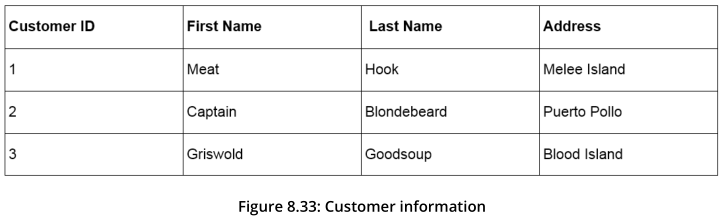

In [30]:
Image('images/customer_information.PNG')

A tabela a seguir mostra a tabela **Order Information**:

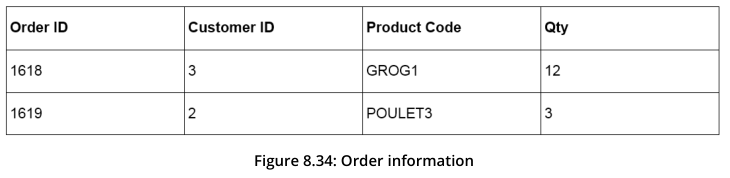

In [31]:
Image('images/order_information.PNG')

Então, com essas informações, podemos querer ver se existem algumas tendências nos itens que são vendidos com base no endereço do cliente. Podemos usar **JOIN** para reunir esses dois conjuntos de informações; usaremos a coluna **Customer ID** para combinar os dois conjuntos de dados e produzir as informações mostradas na tabela a seguir:

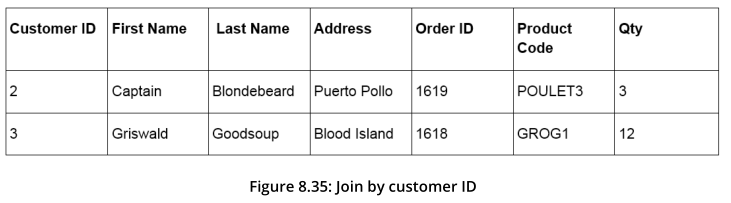

In [32]:
Image('images/join_customers_id.PNG')

Podemos ver no exemplo anterior que a junção incluiu todos os registros em que havia informações disponíveis para o cliente e o pedido. Como tal, o cliente **Meat Hook** foi omitido das informações combinadas, uma vez que nenhuma informação do pedido estava disponível. No exemplo, executamos **INNER JOIN**; há, no entanto, várias junções diferentes disponíveis, e passaremos algum tempo examinando cada uma delas. Veja a seguir um exemplo que mostra o uso de um **INNER JOIN** de **alto desempenho**:

In [36]:
sql = """
	  EXPLAIN ANALYZE SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
	  FROM customers
	  INNER JOIN order_info ON customers.customer_id=order_info.customer_id;
	  """

### Exercício 29: Determinando o Uso de Inner Joins
Neste exercício, investigaremos o uso de junções internas para selecionar com eficiência várias linhas de dados de duas tabelas diferentes. Digamos que nossos bons amigos do departamento de marketing nos deram dois bancos de dados separados: um do SalesForce e outro da Oracle. Poderíamos usar uma instrução JOIN para mesclar as informações correspondentes das duas fontes em uma única fonte. Aqui estão os passos a seguir:

In [14]:
import pandas as pd
from sqlalchemy import create_engine

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")

# Instanciando a Função create_engine com a string de conexão
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="admin",
    host="127.0.0.1",
    port=5432,
    database="smalljoins"))

sql = """
		SELECT *
		FROM customers
		LIMIT 5
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,address
0,5,Murray ...,TheSkull,Plunder Island
1,2,Captain,Blondebeard,Puerto Pollo
2,3,Griswold,Goodsoup,Blood Island
3,4,Guybrush,Threepwood,Melee Island
4,1,Meat,Hook,Melee Island


Execute uma junção interna onde recuperamos todas as colunas de ambas as tabelas sem duplicar a coluna **customer_id** para replicar os resultados anteriores. Vamos definir a tabela da esquerda como **customers** e a tabela da direita como **order_info**. Então, para ser claro, queremos todas as colunas de **customers** e as colunas **order_id**, **product_code** e **qty** de **order_info** quando um cliente fez um pedido. Escreva isso como uma instrução SQL:

In [13]:
sql = """
      SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      FROM customers
      INNER JOIN order_info
       ON customers.customer_id=order_info.customer_id;
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,address,order_id,product_code,qty
0,4,Guybrush,Threepwood,Melee Island,1620,MON123,1.0
1,4,Guybrush,Threepwood,Melee Island,1621,MON636,3.0
2,3,Griswold,Goodsoup,Blood Island,1618,GROG1,12.0
3,2,Captain,Blondebeard,Puerto Pollo,1619,POULET3,3.0
4,5,Murray ...,TheSkull,Plunder Island,1622,MON666,1.0


Salve os resultados desta consulta como uma tabela separada inserindo as palavras-chave **INTO table_name**:

In [9]:
sql = """
      SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      INTO join_results FROM customers INNER JOIN order_info
            ON customers.customer_id=order_info.customer_id;
      """

engine.execute(sql)

Use **EXPLAIN ANALYZE** para obter uma estimativa do tempo necessário para executar a junção. Agora, quanto mais rápido é a junção?

In [10]:
sql = """
      EXPLAIN ANALYZE SELECT customers.*, order_info.order_id,order_info.product_code, order_info.qty FROM customers INNER JOIN order_info ON customers.customer_id=order_info.customer_id;
      """

engine.execute(sql).fetchall()

[('Hash Join  (cost=1.11..22.01 rows=22 width=532) (actual time=0.030..0.033 rows=5 loops=1)',),
 ('  Hash Cond: (order_info.customer_id = customers.customer_id)',),
 ('  ->  Seq Scan on order_info  (cost=0.00..18.60 rows=860 width=66) (actual time=0.012..0.013 rows=5 loops=1)',),
 ('  ->  Hash  (cost=1.05..1.05 rows=5 width=474) (actual time=0.010..0.011 rows=5 loops=1)',),
 ('        Buckets: 1024  Batches: 1  Memory Usage: 9kB',),
 ('        ->  Seq Scan on customers  (cost=0.00..1.05 rows=5 width=474) (actual time=0.006..0.006 rows=5 loops=1)',),
 ('Planning Time: 0.214 ms',),
 ('Execution Time: 0.070 ms',)]

Selecione todos os valores **customer_id** que estão em **order_info** e use **EXPLAIN ANALYZE** para descobrir quanto tempo leva para executar essas consultas individuais:

In [11]:
sql = """
      EXPLAIN ANALYZE SELECT *
      FROM customers
      WHERE customer_id IN (SELECT customer_id FROM order_info);
      """

engine.execute(sql).fetchall()

[('Hash Join  (cost=21.86..25.50 rows=2 width=474) (actual time=0.030..0.032 rows=4 loops=1)',),
 ('  Hash Cond: (order_info.customer_id = customers.customer_id)',),
 ('  ->  HashAggregate  (cost=20.75..22.75 rows=200 width=8) (actual time=0.010..0.011 rows=4 loops=1)',),
 ('        Group Key: order_info.customer_id',),
 ('        Batches: 1  Memory Usage: 40kB',),
 ('        ->  Seq Scan on order_info  (cost=0.00..18.60 rows=860 width=8) (actual time=0.003..0.003 rows=5 loops=1)',),
 ('  ->  Hash  (cost=1.05..1.05 rows=5 width=474) (actual time=0.014..0.014 rows=5 loops=1)',),
 ('        Buckets: 1024  Batches: 1  Memory Usage: 9kB',),
 ('        ->  Seq Scan on customers  (cost=0.00..1.05 rows=5 width=474) (actual time=0.009..0.010 rows=5 loops=1)',),
 ('Planning Time: 0.137 ms',),
 ('Execution Time: 0.062 ms',)]

Observando os resultados dos dois planejadores de consulta, podemos ver que não apenas a junção interna levou menos tempo da consulta sequencial (**0,062 ms** comparado com **0,070 ms**), mas também que retornamos mais informações pelo junção interna, com order_id, product_code e qty também sendo retornados.

10. Execute uma junção à esquerda usando a tabela de clientes como a tabela da esquerda e order_info como a tabela da direita:

In [15]:
sql = """
      SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      FROM customers
      LEFT JOIN order_info
        ON customers.customer_id=order_info.customer_id;
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,address,order_id,product_code,qty
0,4,Guybrush,Threepwood,Melee Island,1620.0,MON123,1.0
1,4,Guybrush,Threepwood,Melee Island,1621.0,MON636,3.0
2,3,Griswold,Goodsoup,Blood Island,1618.0,GROG1,12.0
3,2,Captain,Blondebeard,Puerto Pollo,1619.0,POULET3,3.0
4,5,Murray ...,TheSkull,Plunder Island,1622.0,MON666,1.0
5,1,Meat,Hook,Melee Island,NaN,None,NaN


Observe as diferenças entre a junção esquerda e a junção interna. A junção esquerda incluiu o resultado para **customer_id 4** duas vezes e incluiu o resultado para **Meat Hook** uma vez, embora não haja informações de pedido disponíveis. Ele incluiu os resultados da tabela da esquerda com entradas em branco para informações que não estão presentes na tabela da direita.

Use **EXPLAIN ANALYZE** para determinar o tempo e o custo de execução da junção:

In [16]:
sql = """
      EXPLAIN ANALYZE SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      FROM customers
      LEFT JOIN order_info
      ON customers.customer_id=order_info.customer_id;
      """

engine.execute(sql).fetchall()

[('Hash Right Join  (cost=1.11..22.01 rows=22 width=532) (actual time=0.033..0.038 rows=6 loops=1)',),
 ('  Hash Cond: (order_info.customer_id = customers.customer_id)',),
 ('  ->  Seq Scan on order_info  (cost=0.00..18.60 rows=860 width=66) (actual time=0.004..0.005 rows=5 loops=1)',),
 ('  ->  Hash  (cost=1.05..1.05 rows=5 width=474) (actual time=0.022..0.022 rows=5 loops=1)',),
 ('        Buckets: 1024  Batches: 1  Memory Usage: 9kB',),
 ('        ->  Seq Scan on customers  (cost=0.00..1.05 rows=5 width=474) (actual time=0.015..0.016 rows=5 loops=1)',),
 ('Planning Time: 0.176 ms',),
 ('Execution Time: 0.063 ms',)]

12. Substitua a junção esquerda da etapa 11 por uma junção direita e observe os resultados:

In [18]:
sql = """
     SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
     FROM customers
     LEFT JOIN order_info
     ON customers.customer_id=order_info.customer_id;
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,address,order_id,product_code,qty
0,4,Guybrush,Threepwood,Melee Island,1620.0,MON123,1.0
1,4,Guybrush,Threepwood,Melee Island,1621.0,MON636,3.0
2,3,Griswold,Goodsoup,Blood Island,1618.0,GROG1,12.0
3,2,Captain,Blondebeard,Puerto Pollo,1619.0,POULET3,3.0
4,5,Murray ...,TheSkull,Plunder Island,1622.0,MON666,1.0
5,1,Meat,Hook,Melee Island,NaN,None,NaN


13. Use **EXPLAIN ANALYZE** para determinar o tempo e o custo da junção correta:

In [17]:
sql = """
      EXPLAIN ANALYZE SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      FROM customers
      RIGHT JOIN order_info
        ON customers.customer_id=order_info.customer_id;
      """

engine.execute(sql).fetchall()

[('Hash Left Join  (cost=1.11..22.01 rows=860 width=532) (actual time=0.023..0.025 rows=5 loops=1)',),
 ('  Hash Cond: (order_info.customer_id = customers.customer_id)',),
 ('  ->  Seq Scan on order_info  (cost=0.00..18.60 rows=860 width=66) (actual time=0.010..0.010 rows=5 loops=1)',),
 ('  ->  Hash  (cost=1.05..1.05 rows=5 width=474) (actual time=0.007..0.007 rows=5 loops=1)',),
 ('        Buckets: 1024  Batches: 1  Memory Usage: 9kB',),
 ('        ->  Seq Scan on customers  (cost=0.00..1.05 rows=5 width=474) (actual time=0.004..0.004 rows=5 loops=1)',),
 ('Planning Time: 0.119 ms',),
 ('Execution Time: 0.042 ms',)]

Podemos ver que a junção direita foi marginalmente mais rápida e mais econômica, o que pode ser atribuído ao retorno de uma linha a menos do que na junção esquerda.

14. Insira uma linha adicional em **order_info** com um valor **customer_id** que não está presente na tabela de clientes:

In [20]:
sql = """
      INSERT INTO order_info (order_id, customer_id, product_code,qty)
      VALUES (1623, 6, 'MEL386', 1);
      """

engine.execute(sql)

In [21]:
sql = """
     SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
     FROM customers
     FULL OUTER JOIN order_info
      ON customers.customer_id=order_info.customer_id;
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,address,order_id,product_code,qty
0,4.0,Guybrush,Threepwood,Melee Island,1620.0,MON123,1.0
1,4.0,Guybrush,Threepwood,Melee Island,1621.0,MON636,3.0
2,3.0,Griswold,Goodsoup,Blood Island,1618.0,GROG1,12.0
3,2.0,Captain,Blondebeard,Puerto Pollo,1619.0,POULET3,3.0
4,5.0,Murray ...,TheSkull,Plunder Island,1622.0,MON666,1.0
5,NaN,None,None,None,1623.0,MEL386,1.0
6,1.0,Meat,Hook,Melee Island,NaN,None,NaN


Observe a linha que contém **product_code MEL386**, mas nenhuma informação referente ao cliente; há um caso semelhante para a linha para **customer_id Meat Hook**. A junção externa completa combinou todas as informações disponíveis, mesmo que algumas das informações não estejam disponíveis em nenhuma das tabelas.

16. Use o comando **EXPLAIN ANALYZE** para determinar o desempenho da consulta.

In [22]:
sql = """
      EXPLAIN ANALYZE SELECT customers.*, order_info.order_id, order_info.product_code, order_info.qty
      FROM customers
      FULL OUTER JOIN order_info
            ON customers.customer_id=order_info.customer_id;
      """

engine.execute(sql).fetchall()

[('Hash Full Join  (cost=1.11..22.01 rows=860 width=532) (actual time=0.030..0.034 rows=7 loops=1)',),
 ('  Hash Cond: (order_info.customer_id = customers.customer_id)',),
 ('  ->  Seq Scan on order_info  (cost=0.00..18.60 rows=860 width=66) (actual time=0.005..0.005 rows=6 loops=1)',),
 ('  ->  Hash  (cost=1.05..1.05 rows=5 width=474) (actual time=0.018..0.018 rows=5 loops=1)',),
 ('        Buckets: 1024  Batches: 1  Memory Usage: 9kB',),
 ('        ->  Seq Scan on customers  (cost=0.00..1.05 rows=5 width=474) (actual time=0.013..0.013 rows=5 loops=1)',),
 ('Planning Time: 0.123 ms',),
 ('Execution Time: 0.054 ms',)]

Neste exercício, fomos apresentados aos benefícios de uso e desempenho das junções. Observamos a combinação de informações de duas tabelas separadas usando menos recursos do que as pesquisas individuais exigem, bem como o uso de **OUTER JOIN** para combinar todas as informações com eficiência. Na próxima atividade, desenvolveremos nossa compreensão de junções com um conjunto de dados muito maior.

### Atividade 13: Implementando Junções
Nesta atividade, nosso objetivo é implementar várias junções de desempenho. Nesta atividade, usaremos junções para combinar informações de uma tabela de clientes e informações de um conjunto de dados de email de marketing. Digamos que acabamos de coletar vários registros de e-mail diferentes de vários bancos de dados diferentes. Gostaríamos de destilar as informações em uma única tabela para que possamos realizar uma análise mais detalhada. Aqui estão os passos a seguir:
1. Abra o **PostgreSQL** e conecte-se ao banco de dados **sqlda**.
2. Determine uma lista de clientes (**customer_id**, **first_name** e **last_name**) que receberam um e-mail, incluindo informações sobre o assunto do e-mail e se abriram e clicaram no e-mail. A tabela resultante deve incluir as colunas **customer_id**, **first_name**, **last_name**, **email_subject**, **openend** e **clicked**.
3. Salve a tabela resultante em uma nova tabela, **customer_emails**.
4. Encontre os clientes que abriram ou clicaram em um e-mail.
5. Encontre os clientes que possuem uma concessionária em sua cidade; os clientes que não possuem uma concessionária em sua cidade devem ter um valor em branco para as colunas **city**.
6. Liste os clientes que não possuem concessionárias em sua cidade (dica: um campo em branco é **NULL**).

In [23]:
# Nr 1
import pandas as pd
from sqlalchemy import create_engine

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")

# Instanciando a Função create_engine com a string de conexão
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="admin",
    host="127.0.0.1",
    port=5432,
    database="sqlda"))

# Nr 2

sql = """
		SELECT customers.customer_id, customers.first_name, customers.last_name, emails.opened, emails.clicked
		FROM customers
		INNER JOIN emails
		ON customers.customer_id=emails.customer_id;
"""

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,opened,clicked
0,18,Mareah,Edgell,f,f
1,30,Kath,Rivel,f,f
2,41,Rycca,Oakwell,t,f
3,52,Giusto,Backe,f,f
4,59,Laurene,Lobbe,f,f
...,...,...,...,...,...
418153,49996,Iseabal,Earlam,f,f
418154,49997,Juditha,Caisley,t,f
418155,49998,Chelsie,Plewman,f,f
418156,49999,Danya,Wagon,t,f


In [45]:
sql = """
		SELECT customers.customer_id, customers.first_name, customers.last_name, customers.city
		FROM customers
		LEFT JOIN dealerships on customers.city=dealerships.city
		WHERE customers.city IS NULL
"""

pd.read_sql_query(sql=sql, con=engine)

,customer_id,first_name,last_name,city
0,1,Arlena,Riveles,None
1,12,Tyne,Duggan,None
2,21,Pryce,Geist,None
3,24,Barbi,Lanegran,None
4,30,Kath,Rivel,None
...,...,...,...,...
5462,49970,Tamarra,Pocke,None
5463,49976,Perice,Maultby,None
5464,49984,William,Coldwell,None
5465,49993,Ada,Ince,None


## Funções e gatilhos
Até agora neste módulo, descobrimos como quantificar o desempenho de consultas por meio do planejador de consultas, bem como os benefícios de usar junções para agrupar e extrair informações de várias tabelas de banco de dados. Nesta seção, construiremos consultas e instruções reutilizáveis por meio de funções, bem como a execução automática de funções por meio de retornos de chamada de gatilho.

A combinação desses dois recursos SQL pode ser usada não apenas para executar consultas ou reindexar tabelas à medida que os dados são adicionados/atualizados/removidos do banco de dados, mas também para executar testes de hipóteses e acompanhar os resultados dos testes ao longo da vida do banco de dados.